In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Ori2_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in range(lfp.shape[0]):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 2)


If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = True

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

(1000, 3)


In [4]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [16]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  2%|▏         | 5/300 [00:00<00:06, 44.18it/s]

Training Loss: 1.793006271123886 Validation Loss: 0.5664090812206268


  7%|▋         | 20/300 [00:00<00:06, 45.11it/s]

Training Loss: 1.086329609155655 Validation Loss: 0.35192473232746124


 10%|█         | 30/300 [00:00<00:05, 46.00it/s]

Training Loss: 0.8941370844841003 Validation Loss: 0.29925693571567535


 13%|█▎        | 40/300 [00:00<00:05, 46.42it/s]

Training Loss: 0.8364840149879456 Validation Loss: 0.2852783352136612


 17%|█▋        | 50/300 [00:01<00:05, 46.43it/s]

Training Loss: 0.7210786864161491 Validation Loss: 0.25651659071445465


 20%|██        | 60/300 [00:01<00:05, 46.51it/s]

Training Loss: 0.5648268461227417 Validation Loss: 0.19441114366054535


 23%|██▎       | 70/300 [00:01<00:05, 45.95it/s]

Training Loss: 0.3736950680613518 Validation Loss: 0.13210639357566833


 27%|██▋       | 80/300 [00:01<00:04, 46.63it/s]

Training Loss: 0.32684770599007607 Validation Loss: 0.11703647673130035


 30%|███       | 90/300 [00:01<00:04, 47.21it/s]

Training Loss: 0.29350660368800163 Validation Loss: 0.10785854980349541


 33%|███▎      | 100/300 [00:02<00:04, 47.53it/s]

Training Loss: 0.27718520909547806 Validation Loss: 0.10420079901814461


 37%|███▋      | 110/300 [00:02<00:04, 47.28it/s]

Training Loss: 0.2682313993573189 Validation Loss: 0.1022278182208538


 40%|████      | 120/300 [00:02<00:03, 46.00it/s]

Training Loss: 0.2600781209766865 Validation Loss: 0.10029396042227745


 42%|████▏     | 125/300 [00:02<00:03, 45.77it/s]

Training Loss: 0.25428036227822304 Validation Loss: 0.09911582246422768


 47%|████▋     | 140/300 [00:03<00:03, 45.13it/s]

Training Loss: 0.24912482127547264 Validation Loss: 0.09821480885148048


 50%|█████     | 150/300 [00:03<00:03, 45.10it/s]

Training Loss: 0.2453876957297325 Validation Loss: 0.09718938171863556


 53%|█████▎    | 160/300 [00:03<00:03, 45.87it/s]

Training Loss: 0.24522491917014122 Validation Loss: 0.09800427779555321


 57%|█████▋    | 170/300 [00:03<00:02, 45.87it/s]

Training Loss: 0.2937569357454777 Validation Loss: 0.09437370672821999


 60%|██████    | 180/300 [00:03<00:02, 45.51it/s]

Training Loss: 0.23102623224258423 Validation Loss: 0.0933295264840126


 63%|██████▎   | 190/300 [00:04<00:02, 46.16it/s]

Training Loss: 0.2270135097205639 Validation Loss: 0.09259200841188431


 67%|██████▋   | 200/300 [00:04<00:02, 45.30it/s]

Training Loss: 0.22425679117441177 Validation Loss: 0.09196643903851509


 70%|███████   | 210/300 [00:04<00:01, 45.49it/s]

Training Loss: 0.22040953673422337 Validation Loss: 0.09138121455907822


 72%|███████▏  | 216/300 [00:04<00:01, 48.01it/s]

Training Loss: 0.21744170039892197 Validation Loss: 0.09076573699712753
Training Loss: 0.21471788920462132 Validation Loss: 0.0902564711868763


 79%|███████▉  | 237/300 [00:05<00:01, 47.25it/s]

Training Loss: 0.212793355807662 Validation Loss: 0.0898568443953991


 82%|████████▏ | 247/300 [00:05<00:01, 45.99it/s]

Training Loss: 0.21076513081789017 Validation Loss: 0.08943324908614159


 86%|████████▌ | 257/300 [00:05<00:00, 45.93it/s]

Training Loss: 0.20879033207893372 Validation Loss: 0.08901506289839745


 89%|████████▉ | 267/300 [00:05<00:00, 46.36it/s]

Training Loss: 0.20691374503076077 Validation Loss: 0.08871087804436684


 92%|█████████▏| 277/300 [00:06<00:00, 46.17it/s]

Training Loss: 0.20553037151694298 Validation Loss: 0.08838953077793121


 96%|█████████▌| 287/300 [00:06<00:00, 43.50it/s]

Training Loss: 0.20376323722302914 Validation Loss: 0.08809348940849304


100%|██████████| 300/300 [00:06<00:00, 45.84it/s]


Training Loss: 0.20251143909990788 Validation Loss: 0.08782955631613731


In [17]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

# print("R2: {}".format(r2_score(y, output)))

print("R2 h: {}".format(r2_score(h_lab, h_out)))
print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2 h: 0.8243183589172157
R2 phi: 0.7954273693505121
(128, 3)
(128, 3)


<IPython.core.display.Javascript object>


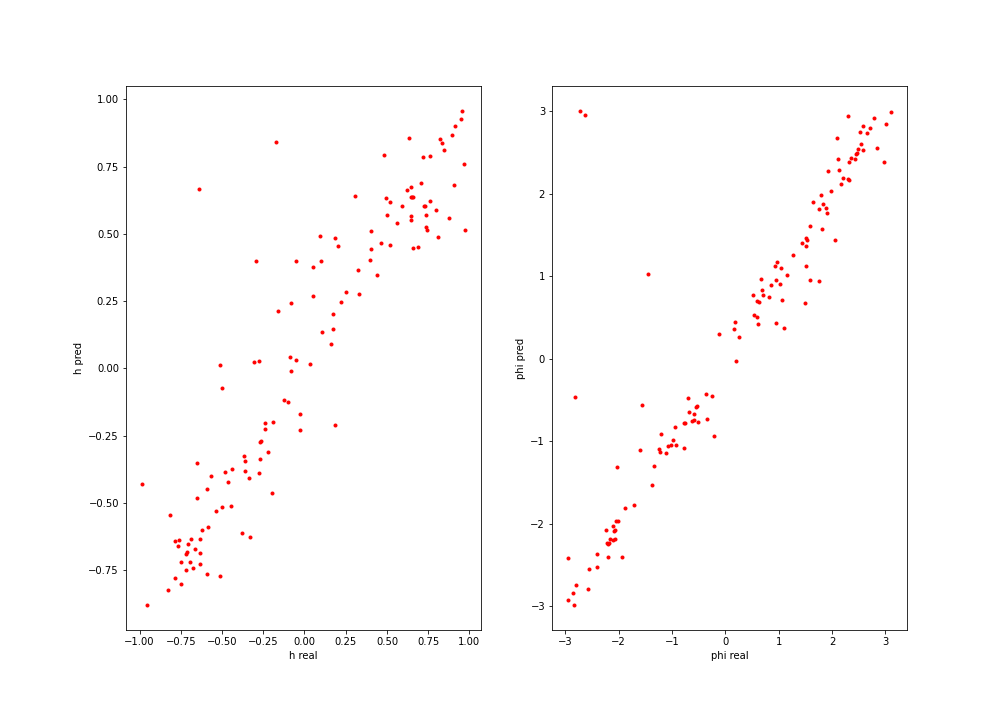

In [19]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

ax_h = plt.subplot(121)
ax_h.scatter(h_lab, h_out, c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(122)
ax_p.scatter(phi_lab, phi_out, c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

# ax_t = plt.subplot(324)
# ax_t.scatter(y[:,3], output[:,3], c='red', marker='.')
# ax_t.set_xlabel('dendrite radius real')
# ax_t.set_ylabel('dendrite radius pred')

# ax_t = plt.subplot(325)
# ax_t.scatter(y[:,4], output[:,4], c='red', marker='.')
# ax_t.set_xlabel('tuft radius real')
# ax_t.set_ylabel('tuft radius pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


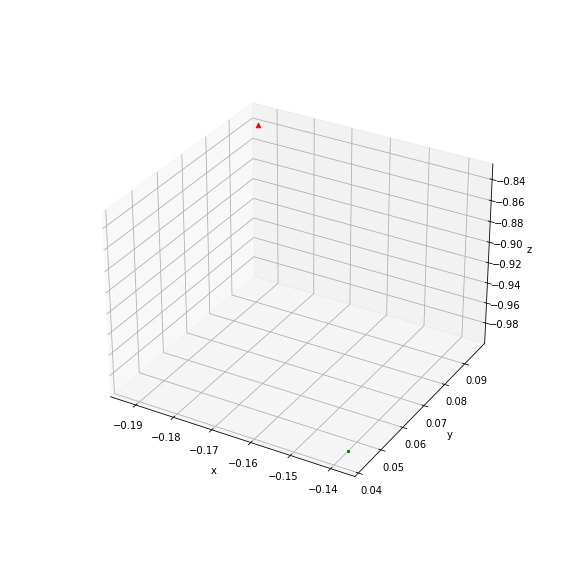

Text(0.5, 0, 'z')

In [20]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()